<a href="https://colab.research.google.com/github/Humam-PS/Deep-Learning/blob/main/Image_classification_using_CNN_CIFAR10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Image Classification Using Convolutional Neural Network (CNN)**
We will classify small images obtained from cifar10 dataset using CNN.
* There are total 10 classes as shown below.

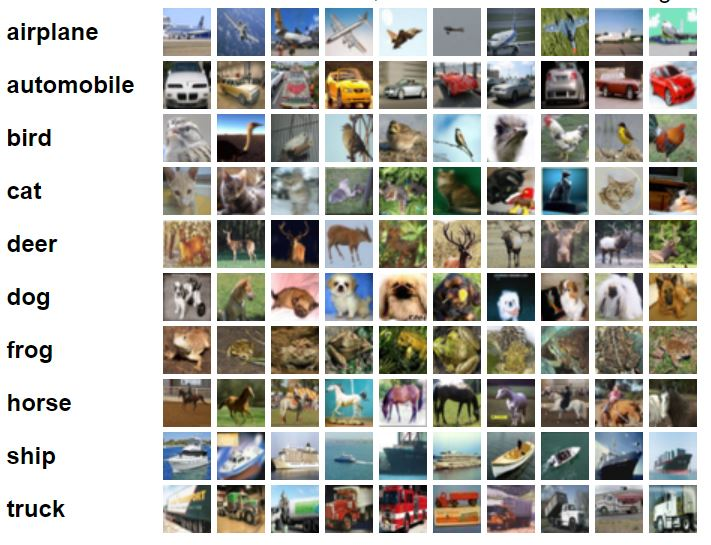

# Importing Python Modules or Files from Drive into Colab

## 1) Mount your google drive in google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2) We'll need to update our path to import from Drive.

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

## 3) Now, we can be able to import our modules or files stuff from drive

In [4]:
### To import using the following code lines, *.py files should be in drive ###
# from myplts import plt_bar, plt_img

In [5]:
### You can import *.ipynb files directly ### - Here, install library

# Method_01
!pip install kora -q
from kora import drive
drive.link_nbs()

from myplts import plt_bar, plt_img

# Method_02
#!cp -r "/content/drive/MyDrive/Colab Notebooks/myplts.ipynb" '/content/'

importing Jupyter notebook from /nbs/myplts.ipynb


# Main Code

## IMPORT MODULES

In [6]:
# keras
import tensorflow as tf
from tensorflow import keras
from keras.datasets.cifar10 import load_data
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten, Dense

# general libs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from IPython.display import Image

In [7]:
# print version of tensorflow framework
print(tf.__version__)

2.4.1


## LOADING CIFAR10 DATASET

In [8]:
(train_images, train_labels), (test_images, test_labels) = load_data()

# Create a classes list
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

### Check the shape of dataset

In [9]:
# 50000 images are encoded as Numpy arrays, each sample is 32x32 pixels and 3 is for RGB channels
print('training dataset: ', 'images:', train_images.shape, 'labels', train_labels.shape)

# 10000 images are encoded as Numpy arrays, each sample is 32x32 pixels and 3 is for RGB channels
print('test dataset:     ', 'images:', test_images.shape, 'labels', test_labels.shape)

training dataset:  images: (50000, 32, 32, 3) labels (50000, 1)
test dataset:      images: (10000, 32, 32, 3) labels (10000, 1)


In [10]:
# Let’s look at the training data (labels = expected output)
    # train_labels: 2D array of digits, ranging from 0 to 9. [10 classes]
    # The images and labels have a one-to-one correspondence.
    
train_labels[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

## VISUALIZE TRAINING & TEST SETS

### VISULAIZE ONE SAMPLE

In [11]:
# Go to the next cell to call this function
def plt_sample(images, labels, idx):
  # reshape the labels array from 2D array to one vector
  labels = labels.reshape(-1,)
  
  plt.figure(figsize=(3,3))
  plt.imshow(images[idx])
  plt.title(classes[labels[idx]])
  plt.colorbar()                    # pixel intensity [0-255]
  plt.show()

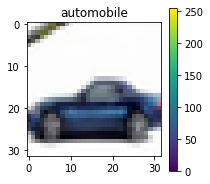

In [12]:
plt_sample(test_images, test_labels, 105)

### VISUALIZE THE FIRST 25 SAMPLES

In [13]:
# Go to the next cell to call this function
def plt_samples(images, labels):
  # reshape the labels array from 2D array to one vector
  labels = labels.reshape(-1,)

  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap = plt.cm.binary)
      plt.title(classes[labels[i]])
  plt.show()

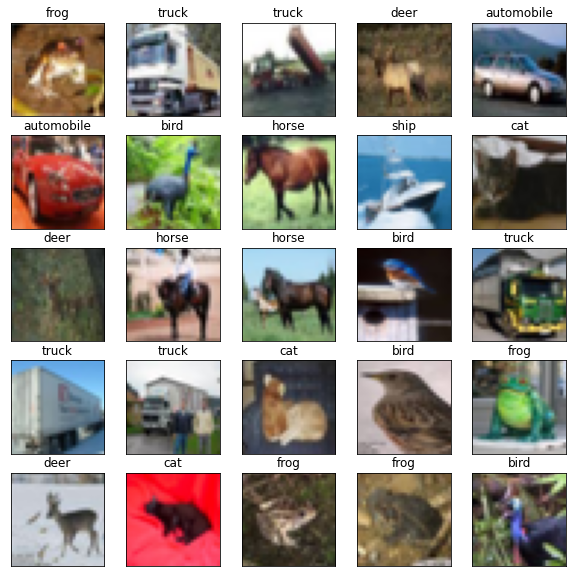

In [14]:
plt_samples(train_images, train_labels)

## PREPROCESS DATASET

### SCALING (NORMALIZING) THE IMAGE DATA

Will scale the intensity value of each pixel to be between [0 - 1] rather than [0 - 255].
* Scale input variables to have similar diagonal covariances.
* Similar covariances → more balanced rate of learning for different weights
* Rescaling to 1 is a good choice

In [15]:
train_images_proc = train_images / 255
test_images_proc  = test_images / 255

In [16]:
# Check the new values for pixels intensities.
print(train_images_proc.shape)
train_images_proc[0]

(50000, 32, 32, 3)


array([[[0.23137255, 0.24313725, 0.24705882],
        [0.16862745, 0.18039216, 0.17647059],
        [0.19607843, 0.18823529, 0.16862745],
        ...,
        [0.61960784, 0.51764706, 0.42352941],
        [0.59607843, 0.49019608, 0.4       ],
        [0.58039216, 0.48627451, 0.40392157]],

       [[0.0627451 , 0.07843137, 0.07843137],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509804, 0.21568627],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117647, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215686, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941176, 0.19607843],
        [0.47058824, 0.32941176, 0.19607843],
        [0.42745098, 0.28627451, 0.16470588]],

       ...,

       [[0.81568627, 0.66666667, 0.37647059],
        [0.78823529, 0.6       , 0.13333333],
        [0.77647059, 0

### RESHAPING THE LABELS

we need to categorically encode the labels.
* rather than each label is one real number, such as 3.
* each label correspond to its image will be a binary vector, such as:
* number 3 will be >>> [0 0 0 1 0 0 0 0 0 0]
* number 8 will be >>> [0 0 0 0 0 0 0 0 1 0]

**Don't do these steps since will use (sparse_categorical_crossentropy) as a loss fuction. So we can use the number.**

>> **Just you can reshape the labels array from 2D array to be one vector.**

In [17]:
train_labels_proc = train_labels.reshape(-1,)  #to_categorical(train_labels)
test_labels_proc  = test_labels.reshape(-1,)   #to_categorical(test_labels)

## CNN NETWORK ARCHITECTURE

### BUILD THE MODEL

Define CNN neural_network (define the keras model), it's not optimal, It has to be optimized.
* MaxPooling layer:
 * reduces the image dimensions while still preserving the features and then reduce the computational cost
* Output Layer:
 * Dense fully connected layer of 10 nodes (softmax)
 * returns an array of 10 probability scores (summing to 1)

* **Increasing # of neurons in the hidden layers, increases the accuracy of the model.**
* **Increasing # of hidden layers, increases the model's accuracy**

In [103]:
cnn = Sequential([
    # cnn
    BatchNormalization(input_shape=(32,32,3)),
    Conv2D(64, (5,5), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.2),

    BatchNormalization(),
    Conv2D(128, (5,5), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.2),

    BatchNormalization(),
    Conv2D(256, (5,5), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.2),


    # dense
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

print(cnn.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_83 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 8, 8, 128)       

### COMPILE AND OPTIMIZE THE MODEL

we need to pick three more things, as part of the compilation step:
    # 1- loss function - Measures the quality of the Network's output on the training data.
    # 2- Optimizer     - mechanism to update the values of the weights of the network.
    # 3- Metrics       - monitors the training to determine when stop

In [104]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
cnn.compile(
    loss      = 'sparse_categorical_crossentropy',
    optimizer = opt,
    metrics   = ['accuracy']
)

## TRAINING THE NEURON MODEL

* Train the neural network: fit the neuron model to the training data

* We are going to train the models in 20 epochs (that is a complete presentation of the trainging dataset)
* This means that we would feed the 50,000 images and labels into the network 20 different times
* No. of epochs = No. of training loops.
* Model is being trained on 391 batches of 128 images each. (391 batches * 128 images = 50,000 images).

* **Increasing # of epochs increases the accuracy of the model.**
* **Decreasing the batch_size increases the accuracy of the model.**

In [105]:
cnn.fit(train_images_proc, train_labels_proc, epochs=10, batch_size=128)

Epoch 1/10
391/391 [==============================] - 6s 13ms/step - loss: 1.7825 - accuracy: 0.3715
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0010 - accuracy: 0.6445
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 0.7628 - accuracy: 0.7341
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 0.6341 - accuracy: 0.7806
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 0.5392 - accuracy: 0.8111
Epoch 6/10
391/391 [==============================] - 5s 13ms/step - loss: 0.4501 - accuracy: 0.8452
Epoch 7/10
391/391 [==============================] - 5s 13ms/step - loss: 0.4050 - accuracy: 0.8570
Epoch 8/10
391/391 [==============================] - 5s 13ms/step - loss: 0.3398 - accuracy: 0.8788
Epoch 9/10
391/391 [==============================] - 5s 13ms/step - loss: 0.3002 - accuracy: 0.8951
Epoch 10/10
391/391 [==============================] - 5s 13ms/step - loss: 0.2565 - accura

## EVALUATE THE NEURON MODEL (TEST)

In [106]:
test_loss, test_acc, = cnn.evaluate(test_images_proc, test_labels_proc)

313/313 [==============================] - 1s 4ms/step - loss: 0.7147 - accuracy: 0.7929


## MAKE PREDICTION

Predict the class of each image, since we have an optimized model now.

In [22]:
predictions = cnn.predict(test_images_proc)

### Classification Report

In [23]:
# Each prediction for each image is an array with 10 probability scores.
print('prediction shape: ', predictions.shape)


# print the classification report:
predicted_classes = [np.argmax(prediction) for prediction in predictions]
print('\nClassification Report: \n', classification_report(test_labels_proc, predicted_classes))

prediction shape:  (10000, 10)

Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.74      0.72      1000
           1       0.77      0.85      0.81      1000
           2       0.68      0.51      0.58      1000
           3       0.55      0.49      0.52      1000
           4       0.67      0.60      0.63      1000
           5       0.65      0.58      0.61      1000
           6       0.78      0.74      0.76      1000
           7       0.69      0.79      0.74      1000
           8       0.73      0.83      0.78      1000
           9       0.69      0.80      0.74      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



## VISUALIZE AND CHECK THE RESULTS

### LOAD ORIGINAL DATASET

* we need to reload the original TEST dataset to use it with plot function

In [24]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

### RESHAPE THE TEST LABELS

* reshape the TEST labels array from 2D array to one vector

In [25]:
test_labels = test_labels.reshape(-1,)
#train_labels = train_labels.reshape(-1,)

### CHECK RESULTS FOR ONE SAMPLE

* Each prediction is an array of 10 numbers (# of classes). Each number represents the confidence that the image corresponds to the each of 10 different classes.

[8.6954749e-01 7.5979261e-03 5.2969135e-02 9.6357072e-04 4.2849060e-04
 7.9788981e-05 7.0749852e-03 6.7156547e-04 1.1949325e-02 4.8717774e-02]

[ airplane is predicted as: airplane (87%) ]



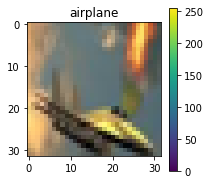

In [26]:
sample = 125
print(predictions[sample])

# pick the index of the element with high confidence
idx_maxProb = np.argmax(predictions[sample])
print(f'\n[ {classes[test_labels[sample]]} is predicted as: {classes[idx_maxProb]} ({100*np.max(predictions[sample]):2.0f}%) ]\n')


# plot the sample
plt.figure(figsize=(3,3))
plt.imshow(test_images[sample]) # cmap=plt.cm.binary
plt.title(classes[test_labels[sample]])
plt.colorbar()
plt.show()

### VISUALIZE THE PREDICTION RESULT 01

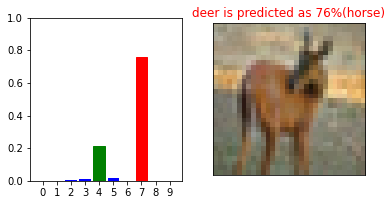

In [27]:
sample = 36
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt_bar(predictions[sample], test_labels[sample])
plt.subplot(1,2,2)
plt_img(predictions[sample], test_labels[sample], test_images[sample], class_names=classes)
plt.show()

### VISUALIZE THE PREDICTION RESULT 02

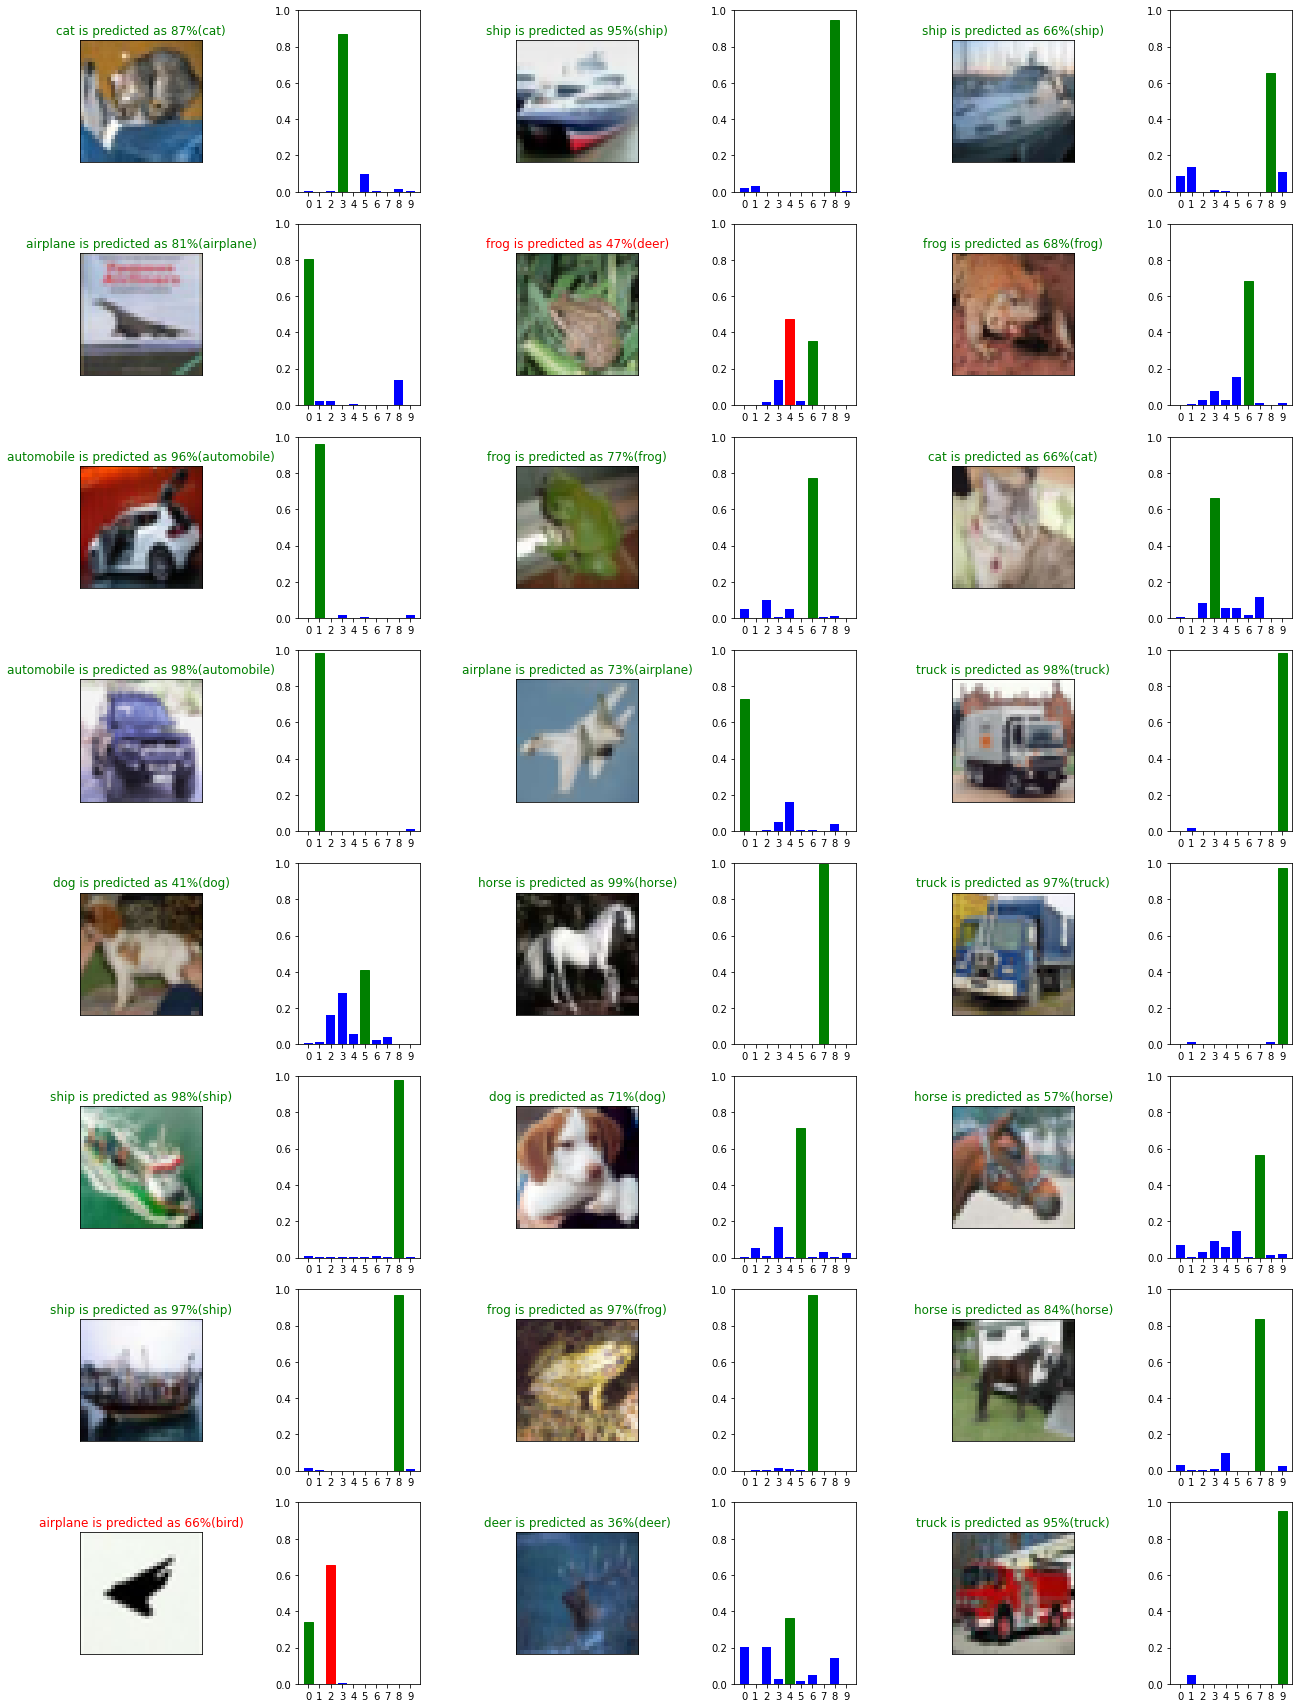

In [28]:
rows = 8
cols = 3

num_images = rows * cols
plt.figure(figsize=(6*cols, 3*rows))

for i in range(num_images):
    plt.subplot(rows,2*cols, 2*i+1)
    plt_img(predictions[i], test_labels[i], test_images[i], class_names=classes)
    plt.subplot(rows,2*cols, 2*i+2)
    plt_bar(predictions[i], test_labels[i])
    
plt.tight_layout()
plt.show()

# NETWORK - PLOT TREE

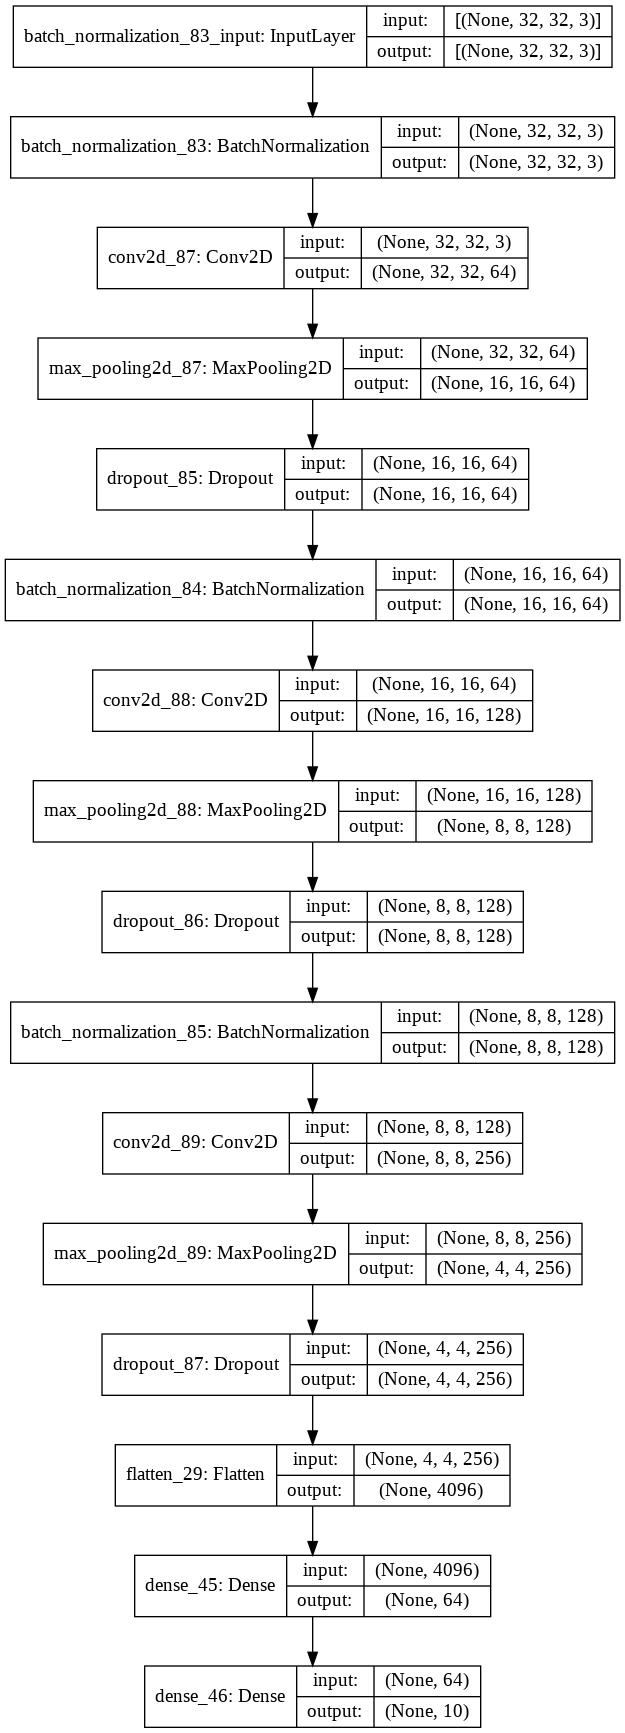

In [110]:
plot_model(cnn, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

# White Board